In [51]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In the lab exercise you built a BaselineModel which was a simple MLP with one hidden layer and trained it on MNIST. You’re now going to explore this model further.


Consider an MLP with a single hidden layer. How wide does the network need to be (how many hidden units) before it overfits(fails to generalise to the test data) on the MNIST training dataset? 


Provide rationale (1 mark) and experimental evidence for your findings (see below), and suggest reasons why they might be so (1 mark).


For practical purposes you’re limited by available GPU memory; don’t try training networks with more than 500,000 hidden units, which have almost 400 million learnable parameters! For experimental evidence you should include training curves (plots of loss and accuracy against epochs) with both the training and test data for a range of different sized models (3 marks).


In [52]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)


# 1. Loading the MNIST data

In [53]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])


In [54]:
# without this agent, downloading will fail!
# https://github.com/pytorch/vision/issues/1938#issuecomment-594503267
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

trainset = MNIST(".", train=True, download=True, transform=transform)

testset = MNIST(".", train=False, download=True, transform=transform)


--2021-03-30 12:08:21--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-30 12:08:22--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [          <=>       ]  33.20M  6.42MB/s    in 5.9s    

2021-03-30 12:08:29 (5.60 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [55]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testloader = DataLoader(testset, batch_size=128, shuffle=True)


In [56]:
len(trainset), len(testset)



(60000, 10000)

# 2. Define Model

In [57]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out


In [58]:
# build the model
def train(hidden_size=512, iters=10):
    model = BaselineModel(784, hidden_size, 10)

    # define the loss function and the optimiser
    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters())

    # the epoch loop
    training_loss_epoch = []
    test_loss_epoch = []
    train_acc_epoch = []
    test_acc_epoch = []
    for epoch in range(iters):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            
            loss = loss_function(outputs, labels)
            loss.backward()            
            optimiser.step()

            # record bath loss
            running_loss += loss.item() * inputs.size(0)

        # the average loss
        training_loss_epoch.append(running_loss / len(trainset))

        test_loss = 0.0
        for inputs, labels in testloader:
            t_outputs = model(inputs)
            t_loss = loss_function(t_outputs, labels)
            # record bath loss
            test_loss += t_loss.item()*inputs.size(0)
        test_loss_epoch.append(test_loss / len(testset))


        # evaluation for each epoch
        model.eval()
        train_acc_epoch.append(predict(model, trainloader))
        test_acc_epoch.append(predict(model, testloader))

        # revert status
        model.train()

    # print(hidden_size, '**** Finished Training ****')

    return training_loss_epoch, test_loss_epoch, train_acc_epoch, test_acc_epoch


def predict(model, dataLoader):
    correct = 0
    total = 0
    
    for data, target in dataLoader:
        total += len(target)
        output = model(data)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum()   

    return ((100.0 * correct) / total).item()


In [72]:
def plotAcc(hidden_size=512, iters = 10, ax1=None, show_loss=False, show_acc=False, show_epoch=False):
    training_loss_epoch, test_loss_epoch, train_acc_epoch, test_acc_epoch = train(hidden_size, iters)

    x = np.arange(iters)
    # sns.set(style="darkgrid")
    sns.set(palette="muted")
    # fig, ax1 = plt.subplots()

    sns.lineplot(x=x, y=training_loss_epoch,  label='training loss', ax=ax1)
    sns.lineplot(x=x, y=test_loss_epoch,label='testing loss', ax=ax1)
    ax1.set_title('hidden_size=' + str(hidden_size))
    if show_epoch:
      ax1.set_xlabel('epoch')

    if show_loss:
      ax1.set_ylabel('loss')

    ax2 = ax1.twinx()
    sns.lineplot(x=x, y=train_acc_epoch, color='m', label='training acc', ax=ax2)
    sns.lineplot(x=x, y=test_acc_epoch, color='r', label='testing acc', ax=ax2)
    if show_epoch:
      ax2.set_xlabel('epoch')
    if show_acc:
      ax2.set_ylabel('accuracy')
    ax2.grid(False)



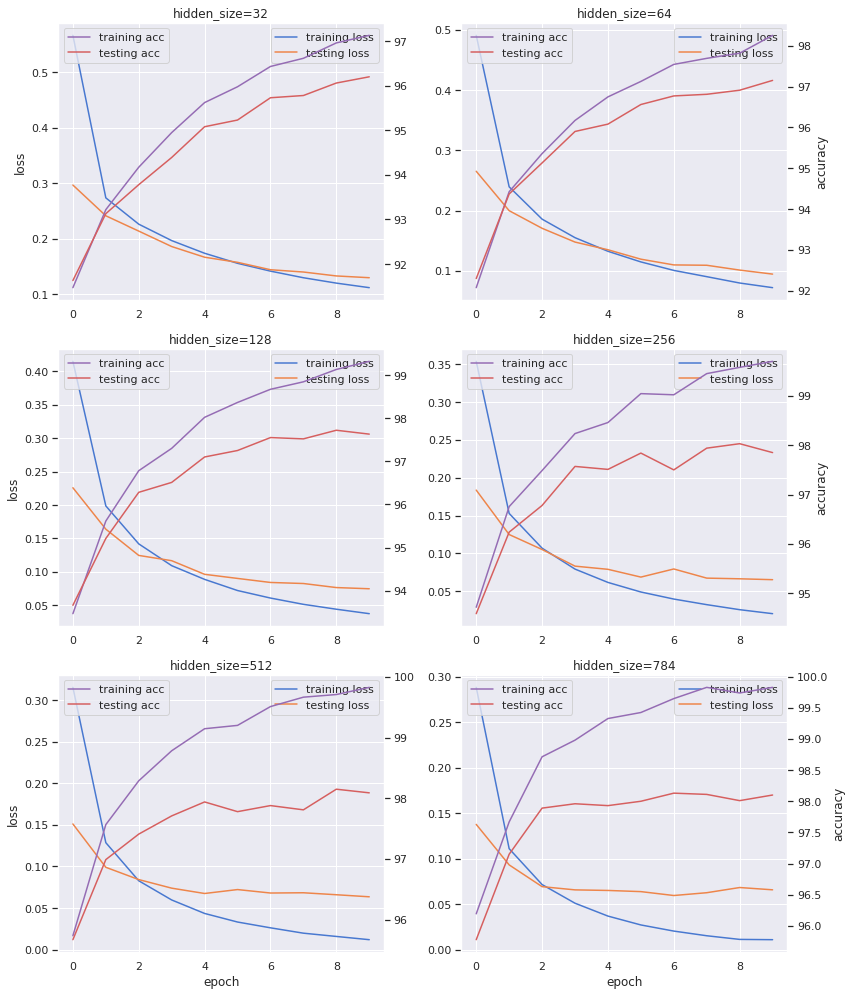

In [73]:
fig, ax = plt.subplots(3, 2, figsize=(12, 14))

for i, s in enumerate([32, 64, 128, 256, 512, 784]):
    show_loss = i in [0, 2, 4]
    show_acc = i in [1, 3, 5]
    show_epoch = i in [4, 5]
    plotAcc(s, 10, ax[i//2, i%2], show_loss, show_acc, show_epoch)

plt.tight_layout()
plt.show()
